In [1]:
%%capture
# Compile and import local pyrossgeo module
import os, sys
owd = os.getcwd()
os.chdir('../../')
sys.path.insert(0,'../../')
!python setup.py build_ext --inplace
os.chdir(owd)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

import pandas as pd
import json

We will generate most of the simulation configuration files based on parameters we feed into the simulation.

Warnings about RAM

Allow to have names in the node populations

Explanation about how node pop and commtuer network awas construced.

Explain what age groups we have

Mention that we set `min_num_moving` quite high here for demonstration purposes.

- ~~Implement density-dependent beta~~
- ~~Set node parameters~~
- Contact matrices, different ones for school.
    - Note that the units of the contact matries are per hour, rather than day
- Write up nicely.
- Plot density dependence, with population also
- Make python version
- Make UK version
- Clean up rest of notebooks.
- Update config documentation
    - Can have NaNs in node parameters.
- Only compute necessary contact matrices at each node
    - Allow user to update this

# Generate the configuration files

### Define model

In [2]:
model = {
    "settings" : {
        "classes" : ["S", "E", "A", "I", "R"],
        "stochastic_threshold_from_below" : [1000, 1000, 1000, 1000, 1000],
        "stochastic_threshold_from_above" : [500, 500, 500, 500, 500],
        "infection_scaling" : "powerlaw",
        "infection_scaling_parameters" : [0, 0.004, 0.5] # a + b * rho^c
    },

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-betaI"], ["A", "-betaA"] ]
    },

    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["I", "betaI"], ["A", "betaA"] ]
    },

    "A" : {
        "linear"    : [ ["E", "gammaE"], ["A", "-gammaA"] ],
        "infection" : []
    },

    "I" : {
        "linear"    : [ ["A", "gammaA"], ["I", "-gammaI"] ],
        "infection" : []
    },

    "R" : {
        "linear"    : [ ["I", "gammaI"] ],
        "infection" : []
    }
}

model_classes = model['settings']['classes']
model_dim = len(model_classes)

### Configuration generation parameters

Here we define some parameters with which all the configuration files will be generated. Edit these if you want to change the simulation.

In [3]:
sim_config_path = 'london_simulation'

min_num_moving = 10 # Remove all commuting edges where less than `min_num_moving` are moving

# Decide which classes are allowed to commute
allow_class = [
    ('S', True),
    ('E', True),
    ('A', True),
    ('Ia1', True),
    ('Ia2', True),
    ('Ia3', True),
    ('Is1', True),
    ('Is2', False),
    ('Is3', False),
    ('R', True),
]

# Decide where to seed with infecteds
seed_pop = [
    (0, 1, 'E', 100),      # Home, age group, model class, seed quantity
    (10, 2, 'E', 100),      
    (23, 0, 'E', 100),     
    (622, 4, 'E', 100),
    (232, 4, 'E', 100)
]

# Node parameters

n_betaI = 0.3
n_betaA = 0.3
n_gammaE = 1/3.0
n_gammaA = 1/3.0
n_gammaI = 1/3.0

# Cnode parameters

cn_betaI = n_betaI
cn_betaA = n_betaA
cn_gammaE = n_gammaE
cn_gammaA = n_gammaA
cn_gammaI = n_gammaI

# Time steps

t_start = 0
t_end = 24*60*40

_, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  1*60),
    (7*60,  2),
    (10*60, 2*60),
    (17*60, 2),
    (19*60, 2*60)
], end_time=24*60)

### Format the commuting network

In [4]:
cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path)

#### Set which classes are allowed to commute

# Drop the current allow_O columns
cn = cn.iloc[:,:10]

# Set allow settings
for O, allow_O in allow_class:
    cn[ "Allow %s" % O ] = 1 if allow_O else 0
    
# Allow people to return home
cn.loc[ cn['Home'] == cn['To'],"Allow %s" % allow_class[0][0]:] = 1

#### Remove commuting edges where fewer than `min_num_moving` people are commuting

delete_rows = []

for i, row in cn.loc[ cn['Home'] == cn['From'] ].iterrows():
    if row['# to move'] < min_num_moving:
        delete_rows.append(i)
        delete_rows.append(i+1) # Delete the returning commuting edge as well

cn = cn.reset_index()
cn = cn.drop(delete_rows)
cn = cn.drop(columns='index')

cn.loc[cn['ct1'] == cn['ct2'], 'ct2'] += 0.1

cn.head()

,Home,From,To,Age,# to move,% to move,t1,t2,ct1,ct2,Allow S,Allow E,Allow A,Allow Ia1,Allow Ia2,Allow Ia3,Allow Is1,Allow Is2,Allow Is3,Allow R
2,0,0,180,4,10,-1,8.935442,9.000000,9.000000,9.166667,1,1,1,1,1,1,1,0,0,1
3,0,180,0,4,-1,1,17.000000,17.064558,17.064558,17.231224,1,1,1,1,1,1,1,1,1,1
4,0,0,180,5,13,-1,8.935442,9.000000,9.000000,9.166667,1,1,1,1,1,1,1,0,0,1
5,0,180,0,5,-1,1,17.000000,17.064558,17.064558,17.231224,1,1,1,1,1,1,1,1,1,1
16,0,0,185,5,19,-1,8.969720,9.000000,9.000000,9.166667,1,1,1,1,1,1,1,0,0,1


### Populate the network

Our `node_populations.csv` currently only has the total population for each age group at each node. In order to use it for the simulation, we must populate it with the model classes, as well as seed some infections.

In [5]:
tot_pop = pd.read_csv("%s/node_populations.csv" % sim_config_path)
tot_pop.head()

,Home,Location,N(0-4),N(5-10),N(11-15),N(16-24),N(25-34),N(35-49),N(50-64),N(65-74),N(75+)
0,0,0,414,601,250,910,1333,1624,1695,839,654
1,1,1,636,904,436,765,1057,1476,1036,432,550
2,2,2,845,1067,503,1094,1734,2261,1713,662,585
3,3,3,441,534,265,796,930,1113,1145,432,566
4,4,4,934,1189,562,1078,1517,2116,1404,485,397


In [6]:
# Create all model classes, and set everyone to be susceptible

npop = pd.DataFrame()
npop['Home'] = tot_pop['Home']
npop['Location'] = tot_pop['Location']

for _cn, _cd in tot_pop.iloc[:,2:].iteritems():
    for O in model['settings']['classes']:
        npop["%s%s" % (O, _cn[1:])] = 0
        
    npop["%s%s" % ("S", _cn[1:])] = _cd
    
# Seed with infecteds

for home, age, O, seed_quantity in seed_pop:
    row_i = npop[npop['Home'] == home].index[0]
    col_i = 2 + age*model_dim
    S = npop.iloc[row_i,col_i]
    npop.iloc[row_i, col_i + model_classes.index('E')] = seed_quantity
    npop.iloc[row_i, col_i] -= seed_quantity

### Setting the node and cnode parameters

We need to add rows giving the model parameters in `node_parameters.csv` and `cnode_parameters.csv`, which currently only has the areas of each geographical node:

In [7]:
nparam = pd.read_csv('london_simulation/node_parameters.csv')
cnparam = pd.read_csv('london_simulation/cnode_parameters.csv')
nparam.head()

,Home,Location,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
0,0,0,ALL,2.905399,NaN,NaN,NaN,NaN,NaN
1,1,1,ALL,2.165634,NaN,NaN,NaN,NaN,NaN
2,2,2,ALL,2.143565,NaN,NaN,NaN,NaN,NaN
3,3,3,ALL,2.490215,NaN,NaN,NaN,NaN,NaN
4,4,4,ALL,1.186180,NaN,NaN,NaN,NaN,NaN


In [8]:
cnparam['betaI'] = cn_betaI
cnparam['betaA'] = cn_betaA
cnparam['gammaE'] = cn_gammaE
cnparam['gammaA'] = cn_gammaA
cnparam['gammaI'] = cn_gammaI

nparam = nparam.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'Age' : 'ALL',
    'betaI' : n_betaI,
    'betaA' : n_betaA,
    'gammaE' : n_gammaE,
    'gammaA' : n_gammaA,
    'gammaI' : n_gammaI,
}, ignore_index=True)

nparam.iloc[-2:-1,:]

,Home,Location,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
982,982,982,ALL,1.986049,NaN,NaN,NaN,NaN,NaN


### Contact matrices

Define the contact matrices

In [9]:
C_home= np.array( [
    [5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28,4.23],
    [4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28],
    [4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33],
    [4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4],
    [4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48],
    [4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58],
    [4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69],
    [4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83],
    [4.23,4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0],
] )
    
C_school = np.array( [
    [8.0,7.83,7.69,0.25,0.19,0.15,0.12,0.1,0.09],
    [7.83,8.0,7.83,0.26,0.19,0.15,0.12,0.1,0.09],
    [7.69,7.83,8.0,0.26,0.19,0.15,0.12,0.11,0.09],
    [0.25,0.26,0.26,0.27,0.2,0.15,0.13,0.11,0.09],
    [0.19,0.19,0.19,0.2,0.2,0.16,0.13,0.11,0.09],
    [0.15,0.15,0.15,0.15,0.16,0.16,0.13,0.11,0.09],
    [0.12,0.12,0.12,0.13,0.13,0.13,0.13,0.11,0.1],
    [0.1,0.1,0.11,0.11,0.11,0.11,0.11,0.11,0.1],
    [0.09,0.09,0.09,0.09,0.09,0.09,0.1,0.1,0.1]
])

C_work = np.array( [
    [0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07],
    [0.07,0.09,0.08,0.08,0.08,0.08,0.08,0.08,0.08],
    [0.07,0.08,0.1,0.1,0.09,0.09,0.09,0.09,0.09],
    [0.07,0.08,0.1,0.12,0.12,0.11,0.11,0.11,0.11],
    [0.07,0.08,0.09,0.12,0.15,0.15,0.14,0.14,0.14],
    [0.07,0.08,0.09,0.11,0.15,0.2,0.19,0.19,0.19],
    [0.07,0.08,0.09,0.11,0.14,0.19,6.0,5.83,5.69],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.83,6.0,5.83],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.69,5.83,6.0]
])

C_transport = np.array( [
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0]
])

contact_matrices = {
    'C' : C_home + C_school + C_work,
    'C_commute' : C_transport
}

In [10]:
ncm = pd.DataFrame(columns=['Home', 'Location'] + model['settings']['classes'])

ncm = ncm.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'A' : 'C',
    'I' : 'C'
}, ignore_index=True)

In [11]:
cncm = pd.DataFrame(columns=['Home', 'From', 'To'] + model['settings']['classes'])

cncm = cncm.append({
    'Home' : 'ALL',
    'From' : 'ALL',
    'To' : 'ALL',
    'A' : 'C_commute',
    'I' : 'C_commute'
}, ignore_index=True)

## Run simulation

In [12]:
sim = pyrossgeo.Simulation()

X_state = sim.initialize(
    model_dat = model,
    commuter_networks_dat = cn,
    node_populations_dat = npop,
    node_parameters_dat = nparam,
    cnode_parameters_dat = cnparam,
    contact_matrices_dat = contact_matrices,
    node_cmatrices_dat = ncm,
    cnode_cmatrices_dat = cncm
)

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=len(dts), steps_per_print=len(dts))

ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

ts_days = ts / (24*60)
ts_hours = ts / 60

Step 0 out of 6560
Step 164 out of 6560
Step 328 out of 6560
Step 492 out of 6560
Step 656 out of 6560
Step 820 out of 6560
Step 984 out of 6560
Step 1148 out of 6560
Step 1312 out of 6560
Step 1476 out of 6560
Step 1640 out of 6560
Step 1804 out of 6560
Step 1968 out of 6560
Step 2132 out of 6560
Step 2296 out of 6560
Step 2460 out of 6560
Step 2624 out of 6560
Step 2788 out of 6560
Step 2952 out of 6560
Step 3116 out of 6560
Step 3280 out of 6560
Step 3444 out of 6560
Step 3608 out of 6560
Step 3772 out of 6560
Step 3936 out of 6560
Step 4100 out of 6560
Step 4264 out of 6560
Step 4428 out of 6560
Step 4592 out of 6560
Step 4756 out of 6560
Step 4920 out of 6560
Step 5084 out of 6560
Step 5248 out of 6560
Step 5412 out of 6560
Step 5576 out of 6560
Step 5740 out of 6560
Step 5904 out of 6560
Step 6068 out of 6560
Step 6232 out of 6560
Step 6396 out of 6560


## Plot the result

Text(0.5, 0, 'Days')

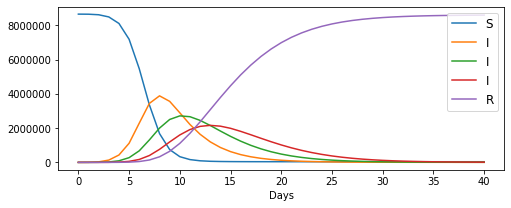

In [13]:
plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1)
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
I = np.sum(network_data[:,:,3], axis=1)
R = np.sum(network_data[:,:,4], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E, label="I")
plt.plot(ts_days, A, label="I")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')

In [14]:
import pickle
import tempfile
import geopandas as gpd
from geopandas.plotting import plot_polygon_collection
from matplotlib import animation

tmp_dir = tempfile.TemporaryDirectory()

In [15]:
geometry_msoa = gpd.read_file("london_geo/london_msoa_shapes/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")
geometry_msoa = geometry_msoa.rename(columns={'msoa11cd':'msoa'})

In [16]:
# Reproduce the node table (copied from "London Commute Network.ipynb")
boroughs = ["City of London", "Camden", "Greenwich", "Hackney", "Hammersmith and Fulham", "Islington", "Kensington and Chelsea", 
            "Lambeth", "Lewisham", "Southwark", "Tower Hamlets", "Wandsworth", "Westminster", "Barking and Dagenham", "Barnet", "Bexley", "Brent", 
            "Bromley", "Croydon", "Ealing", "Enfield", "Haringey", "Harrow", "Havering", "Hillingdon", "Hounslow", "Kingston upon Thames", 
            "Merton", "Newham", "Redbridge", "Richmond upon Thames", "Sutton", "Waltham Forest"]
msoa_to_lad = pd.read_csv('london_geo/data/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv', encoding="latin_1")
lads_london = msoa_to_lad[msoa_to_lad.ladnm.isin(boroughs).fillna(False)][['ladcd']].drop_duplicates().rename(columns={'ladcd':'lad'})
msoas_london = msoa_to_lad[msoa_to_lad.ladnm.isin(boroughs).fillna(False)][['msoa11cd']].drop_duplicates().rename(columns={'msoa11cd':'msoa'})

age_commute_table = pd.read_csv("london_geo/data/wu02ew_msoa.csv")
londoners_work_london = age_commute_table[age_commute_table['Area of residence'].isin(msoas_london.msoa)]
londoners_work_london = londoners_work_london[londoners_work_london['Area of workplace'].isin(msoas_london.msoa)]
londoners_work_london = londoners_work_london.rename(columns={'All categories: Age 16 and over':'All Ages'})
node_table = londoners_work_london[['Area of residence']].drop_duplicates().reset_index(drop=True).rename(columns={'Area of residence':'msoa'})
node_table['NodeIndex'] = node_table.index

/home/lukas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
sir_data = np.zeros( (location_data.shape[0],location_data.shape[1], 3, location_data.shape[3]) )
sir_data[:,:,0,:] = location_data[:,:,0,:]
sir_data[:,:,1,:] = location_data[:,:,1,:] + location_data[:,:,2,:] + location_data[:,:,3,:]
sir_data[:,:,2,:] = location_data[:,:,4,:]

time_stesp = ts

In [18]:
sir_indices = [[*index] for index, _ in np.ndenumerate(sir_data[0,:,:,:])]
sir_frame = pd.DataFrame(sir_indices, columns=["AgeGroup", "Class", "NodeIndex"])     
s1, s2, s3, s4 = sir_data.shape
n_days = s1
for i in range(s1):
    sir_frame[i] = sir_data.reshape((s1, s2*s3*s4))[i,:]
sir_frame = sir_frame.merge(node_table)

# Useful quantities:
population = sir_frame.sum()[0]
population_per_msoa = sir_frame.groupby('msoa').sum().reset_index()

In [19]:
# Example: Plot percentage of infected in each MSOA at a day
def plot_infected_relative(frame, day, ax, close_plot=True, title_prefix="", legend=True, cax=None): 
    # Plot relative number of infected (wrt the number of people in the node at the time):
    tmp_table = frame.merge(population_per_msoa[['msoa', day]], on='msoa', suffixes=('', '_persons'))
    tmp_table['rel'] = tmp_table[str(day)] / tmp_table[str(day) + '_persons']
    tmp_table = geometry_msoa.merge(tmp_table)
    if legend:
        if cax is None:
            tmp_table.plot(ax = ax, column='rel', vmin=0, vmax=1, legend=True, 
                           legend_kwds={'label': "Relative number of infected"})
        else:
            tmp_table.plot(ax = ax, column='rel', vmin=0, vmax=1, legend=True, cax=cax,
                           legend_kwds={'label': "Relative number of infected"})
    else:
        tmp_table.plot(ax = ax, column='rel', vmin=0, vmax=1, legend=False)
    
    ax.set_title(title_prefix + "Day {}".format(day))
    ax.set_axis_off()
    plt.savefig(tmp_dir.name + '/day-{}.png'.format(day))
    if close_plot:
        plt.close(fig)
    else:
        return plt

def plot_relative(frame, day, ax, title="", legend=True, cax=None): 
    # Plot relative number of infected (wrt the number of people in the node at the time):
    tmp_table = frame.merge(population_per_msoa[['msoa', day]], on='msoa', suffixes=('', '_persons'))
    tmp_table['rel'] = tmp_table[str(day)] / tmp_table[str(day) + '_persons']
    tmp_table = geometry_msoa.merge(tmp_table)
    if legend:
        if cax is None:
            tmp_table.plot(ax = ax, column='rel', vmin=0, vmax=1, legend=True, 
                           legend_kwds={'label': "Relative number of infected"})
        else:
            tmp_table.plot(ax = ax, column='rel', vmin=0, vmax=1, legend=True, cax=cax,
                           legend_kwds={'label': "Relative number of infected"})
    else:
        tmp_table.plot(ax = ax, column='rel', vmin=0, vmax=1, legend=False)
    
    ax.set_title(title)
    ax.set_axis_off()
    return plt
    
susceptible_sir_frame = sir_frame[sir_frame.Class == 0].groupby('msoa').sum().reset_index()
infected_sir_frame = sir_frame[sir_frame.Class == 1].groupby('msoa').sum().reset_index()
recovered_sir_frame = sir_frame[sir_frame.Class == 2].groupby('msoa').sum().reset_index()

KeyError: '[45] not in index'

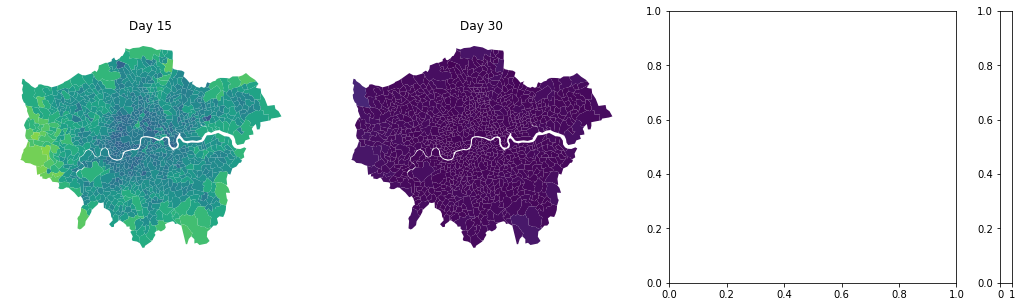

In [20]:
fig, (ax1, ax2, ax3, cax) = plt.subplots(1, 4, figsize=(18, 5), gridspec_kw={'width_ratios':[15, 15, 15, 0.6]})
plot_relative(infected_sir_frame, 15, ax1, title="Day %s" % 15, legend=False)
plot_relative(infected_sir_frame, 30, ax2, title="Day %s" % 30, legend=False)
plot_relative(infected_sir_frame, 45, ax3, title="Day %s" % 45, legend=True, cax=cax)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.suptitle("Percentage of Infected - SIR Model", fontsize=18)
plt.savefig("sir-plot.pdf")

In [ ]:
sum_susceptible_sir = susceptible_sir_frame.sum()
s_vals = [sum_susceptible_sir[i] for i in range(n_days)]
sum_infected_sir = infected_sir_frame.sum()
i_vals = [sum_infected_sir[i] for i in range(n_days)]
sum_recovered_sir = recovered_sir_frame.sum()
r_vals = [sum_recovered_sir[i] for i in range(n_days)]

def plot_seir(day, ax):
    ax.plot(list(range(day)), s_vals[0:day], label="Susceptible")
    ax.plot(list(range(day)), i_vals[0:day], label="Infected")
    ax.plot(list(range(day)), r_vals[0:day], label="Recovered")

    ax.set_xlim(0, n_days)
    ax.set_ylim(0, population)
    ax.legend(loc='center left')


def plot_seir_day(day, close_plot=False):
    fig, axes = plt.subplots(ncols=3, nrows=2, gridspec_kw={'width_ratios':[15, 15, 0.5]}, figsize=(12, 10))

    plot_relative(susceptible_sir_frame, day, axes[0][0], title="Susceptible", legend=False)
    plot_relative(infected_sir_frame, day, axes[0][1], title="Infected", legend=True, cax=axes[0][2])
    plot_relative(recovered_sir_frame, day, axes[1][1], title="Recovered", legend=False)
    plot_seir(day, axes[1][0])
    axes[1][2].set_visible(False)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    fig.suptitle("S(E+A+I)R Model - Day {}".format(day), fontsize=18)
    plt.savefig(tmp_dir.name + '/day-{}.png'.format(day))
    if close_plot:
        plt.close(fig)

# Uncomment this to create the video:
for day in range(n_days):
    if day % 10 == 0:
        print(day, " of ", n_days)
    plot_seir_day(day, close_plot=True)
# This probably only works on Linux (also needs ffmpeg)
os.system('ffmpeg -framerate 10 -i \'{}/day-%d.png\' -c:v libx264 -pix_fmt yuv420p ./sir-animation-no-lockdown.mp4'.format(tmp_dir.name))